# Length Distributions of Genes Predicted by Phanotate, Glimmer, GeneMarkS, and Prodigal

We have run four different gene callers on the 2,133 phage genomes that were in GenBank at the time of download. We have generated several supplemental files that allow us to perform some statistical analysis 

[genome, stop position, length, gene caller(s)]

The gene callers is a - separated list of all the callers that identified the gene at that location. The stop position is the enf of the gene, and the length is the length, in nt, of the gene.

In this analysis, we start by looking at all of the data, and then we re-read the file and process just the genes that unique to each gene caller.

In [1]:
# import our environment
import os
import sys

import gzip
import json
from math import log,e,sqrt

%matplotlib inline
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison

In [2]:
# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

# Create a dataframe with each gene callers data

This data frame has all the counts for everything but split out. So if I gene is called by genemark-glimmer-prodigal-phanotate the entry appears 4 times, once for each of the callers. We also store the number of times we've seen each gene caller in this data frame so we can extract the unique callers out of it later.

Since we know *a priori* that the data is not normally distributed we add a log(x+1) column that we can use for the statistical analysis.

We use a simple histogram to visualize the data from each caller.

In [3]:
lgth={}
with gzip.open("phanotate_all_orf_positions.txt.gz", "rt") as f:
    for l in f:
        p=l.strip().split("\t")
        if len(p) < 4:
            sys.stderr.write(f"{l}\n")
            continue
        if p[3] not in lgth:
            lgth[p[3]] = []
        lgth[p[3]].append(int(p[2]))
ac = pd.DataFrame()
for l in lgth:
    p = l.split("-")
    num = len(p)
    for caller in p:
        d = pd.DataFrame({"num_callers" : num, "caller" : caller, "length" : lgth[l]})
        ac = ac.append(d)
ac['loglength']=ac.apply(lambda x: log(x['length'] + 1), axis=1)
ac.head()

,caller,length,num_callers,loglength
0,genemark,195,4,5.278115
1,genemark,306,4,5.726848
2,genemark,228,4,5.433722
3,genemark,279,4,5.634790
4,genemark,483,4,6.182085


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f52aa11d0>,
      dtype=object)

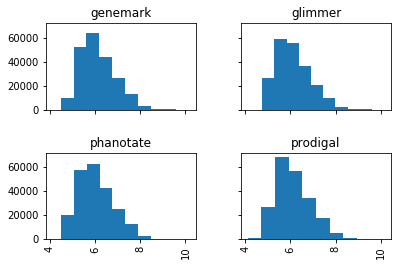

In [4]:
ac.hist(by="caller", column='loglength', sharex=True, sharey=True)

## Summary Statistics

This will be useful in our paper!

In [5]:
for c in pd.unique(ac.caller):
    d = ac[ac.caller == c]
    count = d.length.count()
    m = d.length.min()
    x = d.length.max()
    n = round(d.length.mean(), 2)
    e = round(d.length.median(), 2)
    s = round(d.length.std(), 2)
    #print(f"Gene caller: {c}, Min: {m}, Max: {x}, Mean: {n}, Median: {e}, stdev: {s}")
    printmd(f"{c} (n: {count}, *M* = {n}, *SD* = {s})")

<span style='color:None'>genemark (n: 213101, *M* = 627.78, *SD* = 718.75)</span>

<span style='color:None'>glimmer (n: 211278, *M* = 630.66, *SD* = 719.26)</span>

<span style='color:None'>prodigal (n: 211886, *M* = 630.9, *SD* = 719.85)</span>

<span style='color:None'>phanotate (n: 225518, *M* = 602.53, *SD* = 708.33)</span>

## Compare the mean of the lengths of the proteins

We use an ANOVA to determine whether there is any difference in the mean of the lengths of the proteins. Note that we are using ln(length) here since we have a non-normal distribution.

In [6]:
mod = ols('loglength ~ caller', data=ac).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("\nReport as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['caller']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['caller'], 2),
    round(aov_table.get("PR(>F)")['caller'], 4)
))

                 sum_sq        df           F         PR(>F)
caller       778.219774       3.0  440.453815  5.652033e-286
Residual  507547.319505  861779.0         NaN            NaN



<span style='color:None'>
Report as: *F*(3, 861779) = 440.45, *p* = 0.0</span>

### Use Tukey's honestly significant difference test to compare the data

This performs pairwise comparisons on our data. The NULL hypothesis is that there is no statistical difference in the means of the two samples. If we reject that NULL hypothesis (reject == True) then we have reason to believe that there is a significan difference in the means of the samples.

In [7]:
rec = pairwise_tukeyhsd(ac['loglength'], ac['caller'])
print(rec)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
 genemark  glimmer   0.0065   0.0005  0.0126  True 
 genemark phanotate -0.0634  -0.0694 -0.0574  True 
 genemark  prodigal  0.0075   0.0014  0.0135  True 
 glimmer  phanotate -0.0699  -0.0759 -0.0639  True 
 glimmer   prodigal  0.001   -0.0051  0.007  False 
phanotate  prodigal  0.0709   0.0649  0.0769  True 
---------------------------------------------------


# Number of gene callers that identify a gene

We can also determine whether there is any statistical difference between the mean lengths of genes based on how many gene callers identify it.

We would expect, *a priori*, that longer genes would be reported by more gene callers!

As we can see, there is no difference in the mean lengths of proteins identified by one or two gene callers, but all others are different.

In [8]:
mod = ols('length ~ num_callers', data=ac).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("\nReport as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['num_callers']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['num_callers'], 2),
    round(aov_table.get("PR(>F)")['num_callers'], 4)
))
print()
rec = pairwise_tukeyhsd(ac['length'], ac['num_callers'])
print(rec.summary())

                   sum_sq        df             F  PR(>F)
num_callers  1.067837e+10       1.0  21312.854892     0.0
Residual     4.317779e+11  861781.0           NaN     NaN



<span style='color:None'>
Report as: *F*(1, 861781) = 21312.85, *p* = 0.0</span>


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  1      2    11.0368  -8.2005   30.274  False 
  1      3    74.2389  59.1295  89.3482   True 
  1      4    451.7414 439.0117 464.4711  True 
  2      3    63.2021  46.3875  80.0166   True 
  2      4    440.7046 425.9913 455.418   True 
  3      4    377.5025 368.8595 386.1456  True 
-----------------------------------------------


# Unique Genes

These are the set of genes that have only been identified by a single gene caller. We can filter based on `num_callers` field in our data frame, and then test whether there is any difference here.

In [9]:
sc = ac[ac.num_callers == 1]
sc.head()

,caller,length,num_callers,loglength
0,phanotate,105,1,4.663439
1,phanotate,120,1,4.795791
2,phanotate,165,1,5.111988
3,phanotate,90,1,4.510860
4,phanotate,210,1,5.351858


# Min, Max, Mean and StDev for each Gene Caller alone

Provide information about each of the genes in the entire data set. 

In [10]:
for c in pd.unique(sc.caller):
    d = sc[sc.caller == c]
    m = d.length.min()
    x = d.length.max()
    n = round(d.length.mean(), 2)
    e = round(d.length.median(), 2)
    s = round(d.length.std(), 2)
    #print(f"Gene caller: {c}, Min: {m}, Max: {x}, Mean: {n}, Median: {e}, stdev: {s}")
    printmd(f"{c} (*M* = {n}, *SD* = {s})")

<span style='color:None'>phanotate (*M* = 210.1, *SD* = 245.94)</span>

<span style='color:None'>prodigal (*M* = 226.87, *SD* = 151.58)</span>

<span style='color:None'>genemark (*M* = 183.43, *SD* = 109.06)</span>

<span style='color:None'>glimmer (*M* = 217.22, *SD* = 174.35)</span>

# Histogram

A quick plot of the data is always helpful to see what we have.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f905d5160>,
      dtype=object)

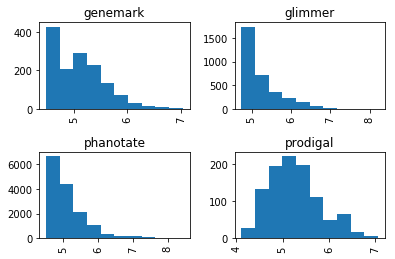

In [11]:
sc.hist(by="caller", column='loglength')

# ANOVA

A one-way anova on the length distribution of the data to test whether there are any significant differences.

For more details on how to correctly report statistics, see [this excellent post](http://my.ilstu.edu/~jhkahn/apastats.html) that describes reporting statistics in APA style. This is what we will use

In [12]:
mod = ols('loglength ~ caller', data=sc).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("\nReport as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['caller']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['caller'], 2),
    round(aov_table.get("PR(>F)")['caller'], 4)
))

               sum_sq       df          F        PR(>F)
caller      51.350353      3.0  56.600959  1.971368e-36
Residual  6307.095531  20856.0        NaN           NaN



<span style='color:None'>
Report as: *F*(3, 20856) = 56.6, *p* = 0.0</span>

# Tukey's Test

Compare the pairwise sets of proteins to determine if there are any differences. Note that if `reject == True` it means that we reject the NULL hypothesis that there is no difference in the populations from which the samples were taken. If `reject == False` it suggests the samples are the same.

In [13]:
rec = pairwise_tukeyhsd(sc['loglength'], sc['caller'])
print(rec)

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
 genemark  glimmer   0.1289   0.084   0.1738  True 
 genemark phanotate  0.0186  -0.0206  0.0578 False 
 genemark  prodigal  0.1658   0.1079  0.2238  True 
 glimmer  phanotate -0.1103  -0.1374 -0.0831  True 
 glimmer   prodigal  0.0369  -0.0136  0.0875 False 
phanotate  prodigal  0.1472   0.1016  0.1928  True 
---------------------------------------------------


# Phanotate Hit/No Hit Data

This file has a list of the lengths of the proteins that are unique to phanotate, and wether they have any similarity to the GenBank non-redundant database.

We read these into a data frame as before.

In [14]:
phnr = pd.DataFrame()
with gzip.GzipFile("phanotate_v_nr_lens.json.gz", 'r') as fin:
    phandata = json.loads(fin.read())
for gc in phandata:
    x=pd.DataFrame({'caller' : gc, 'length' : phandata[gc]})
    phnr = phnr.append(x)
phnr['loglength']=phnr.apply(lambda x: log(x['length'] + 1), axis=1)
phnr.shape

(15755, 3)

# t-test on the two log length columns

We use a t-test to determine whether the two samples are the same or not. Note that here we take a sample of 1,000 elements from our data and test those. It ensures that our sample sizes are the same and a random sample of 1,000 elements will have the same distribution as the whole data set.

In [15]:
for i in pd.unique(phnr.caller):
    n = phnr[phnr['caller'] == i]['length'].count()
    m = round(phnr[phnr['caller'] == i]['length'].mean(), 2)
    s = round(phnr[phnr['caller'] == i]['length'].std(), 2)
    print(f"Sample {i} N: {n} Mean: {m} Stdev {s}")

sampsize = 1000
for i in range(10):
    hn = phnr[phnr['caller'] == "phan_hit_nr"].sample(sampsize)['loglength']
    nh = phnr[phnr['caller'] == "phan_no_hit"].sample(sampsize)['loglength']

    rec = stats.ttest_rel(hn, nh, nan_policy='omit')
    printmd("t test iteration {}: *t*({}) = {}, *p* < {}".format(i, sampsize-1, round(rec.statistic,2), round(rec.pvalue, 4)))

Sample phan_hit_nr N: 4128 Mean: 240.65 Stdev 228.61
Sample phan_no_hit N: 11627 Mean: 229.02 Stdev 261.1


<span style='color:None'>t test iteration 0: *t*(999) = 3.95, *p* < 0.0001</span>

<span style='color:None'>t test iteration 1: *t*(999) = 4.64, *p* < 0.0</span>

<span style='color:None'>t test iteration 2: *t*(999) = 4.08, *p* < 0.0</span>

<span style='color:None'>t test iteration 3: *t*(999) = 3.67, *p* < 0.0003</span>

<span style='color:None'>t test iteration 4: *t*(999) = 4.39, *p* < 0.0</span>

<span style='color:None'>t test iteration 5: *t*(999) = 3.07, *p* < 0.0022</span>

<span style='color:None'>t test iteration 6: *t*(999) = 4.67, *p* < 0.0</span>

<span style='color:None'>t test iteration 7: *t*(999) = 3.15, *p* < 0.0017</span>

<span style='color:None'>t test iteration 8: *t*(999) = 4.05, *p* < 0.0001</span>

<span style='color:None'>t test iteration 9: *t*(999) = 3.67, *p* < 0.0003</span>